Cloning into 'Affordance3DHighlighter'...
remote: Enumerating objects: 247, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 247 (delta 2), reused 1 (delta 0), pack-reused 238 (from 1)
Receiving objects: 100% (247/247), 2.64 MiB | 6.04 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [2]:
import os

os.chdir('/content/Affordance3DHighlighter')

In [ ]:
!pip install gdown
!gdown --id 1siZtGusB1LfQVapTvNOiYi8aeKKAgcDF
!unzip full-shape.zip -d /content/Affordance3DHighlighter/data/

In [ ]:
import pickle

# Load training data
with open('/kaggle/working/Affordance3DHighlighter/data/full_shape_train_data.pkl', 'rb') as train_file:
    train_data = pickle.load(train_file)
# Inspect the contents
print(f"Training Data Type: {type(train_data)}")
print(f"Training Data Example: {train_data[:1]}")

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install kaolin==0.17.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-2.5.1_cu121.html

In [ ]:

import sys
import torch

need_pytorch3d = False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d = True
if need_pytorch3d:
    pyt_version_str = torch.__version__.split("+")[0].replace(".", "")
    version_str = "".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".", ""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install iopath
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        pip_list = !pip freeze
        need_pytorch3d = not any(i.startswith("pytorch3d==") for i in pip_list)
    if need_pytorch3d:
        print(f"failed to find/install wheel for {version_str}")
if need_pytorch3d:
    print("Installing PyTorch3D from source")
    !pip install ninja
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
!pip install open3d

In [ ]:
!mkdir -p data/PittsburghBridge
!wget -P data/PittsburghBridge https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz

In [7]:

from src.mesh import Mesh
from pytorch3d.structures import Pointclouds

from src.convertor import obj_to_pointcloud


def bounding_sphere_normalize(points: torch.Tensor) -> torch.Tensor:
    """
    points: (N,3) tensor of point coords
    Return normalized points in a unit sphere centered at origin.
    """
    center = points.mean(dim=0, keepdim=True)
    max_dist = (points - center).norm(p=2, dim=1).max()
    points_normed = (points - center) / max_dist
    return points_normed


def load_3d_data(file_path, num_points=10000, device="cuda", do_normalize=True):
    """
    Loads 3D data as PyTorch3D Pointclouds from either NPZ point cloud or OBJ mesh.

    Args:
        file_path: Path to either .npz point cloud or .obj mesh file
        num_points: Number of points to sample if loading from mesh
        device: Device to load data on

    Returns:
        Pointclouds object containing points and features
    """
    file_ext = file_path.split('.')[-1].lower()

    if file_ext == 'npz':
        # Load NPZ point cloud directly like in the example
        pointcloud = np.load(file_path)
        verts = torch.Tensor(pointcloud['verts']).to(device)
        rgb = torch.Tensor(pointcloud['rgb']).to(device)

        print("lenght of the data")
        print(len(verts))

        # Subsample if needed
        if len(verts) > num_points:
            idx = torch.randperm(len(verts))[:num_points]
            verts = verts[idx]
            rgb = rgb[idx]

        if do_normalize:
            verts = bounding_sphere_normalize(verts)

        # Return both the points tensor and the Pointclouds object
        point_cloud = Pointclouds(points=[verts], features=[rgb])
        return verts, point_cloud  # Return both

    elif file_ext == 'obj':
        # Load and convert your OBJ file
        points, point_cloud = obj_to_pointcloud(
            file_path,
            num_points=num_points,  # Adjust this number as needed
            device="cuda"  # Use "cpu" if you don't have a GPU
        )
        if do_normalize:
            points = bounding_sphere_normalize(points)
            # here we update the point cloud too
            rgb = point_cloud.features_packed() # shape [N,3]
            point_cloud = Pointclouds(points = [points], features = [rgb])
        return points, point_cloud
        # # Load mesh and sample points
        # mesh = Mesh(file_path)
        # vertices = mesh.vertices

        # # Sample random points
        # idx = torch.randperm(vertices.shape[0])[:num_points]
        # points = vertices[idx].to(device)

        # # Initialize with gray color
        # colors = torch.ones_like(points) * 0.7

        # return Pointclouds(points=[points], features=[colors])

    else:
        raise ValueError(f"Unsupported file format: {file_ext}. Only .npz and .obj are supported.")



Warp 1.5.1 initialized:
   CUDA Toolkit 12.6, Driver 12.2
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "Tesla T4" (15 GiB, sm_75, mempool enabled)
   Kernel cache:
     /root/.cache/warp/1.5.1


In [ ]:
def print_grad_fn(tensor, depth=0):
    """Recursively print the gradient function graph"""
    if tensor.grad_fn is None:
        print("  " * depth + "None (leaf tensor)")
        return

    print("  " * depth + str(tensor.grad_fn))
    for fn in tensor.grad_fn.next_functions:
        if fn[0] is not None:
            print("  " * (depth + 1) + str(fn[0]))

In [8]:

from src.render.cloud_point_renderer import MultiViewPointCloudRenderer
from src.save_results import save_renders, save_results
from src.neural_highlighter import NeuralHighlighter
from src.Clip.loss_function import clip_loss
from src.Clip.clip_model import get_clip_model, encode_text, setup_clip_transforms

import torch
import numpy as np
import random
from tqdm import tqdm

# Constrain most sources of randomness
# (some torch backwards functions within CLIP are non-determinstic)
# Set a consistent seed for reproducibility
seed = 0  # You can use any integer value
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


def optimize_point_cloud(points, clip_model, renderer, encoded_text, log_dir: str, **kwargs):
    num_iterations = kwargs.get('num_iterations', 1000)
    learning_rate = kwargs.get('learning_rate', 1e-4)
    depth = kwargs.get('depth', 5)
    width = kwargs.get('network_width', 256)
    n_views = kwargs.get("n_views", 4)
    n_augs = kwargs.get('n_augs', 1)
    clipavg = kwargs.get('clipavg', 'view')
    device = kwargs.get('device', 'cuda')

    # Initialize network and optimizer
    net = NeuralHighlighter(
        depth=depth,  # Number of hidden layers
        width=width,  # Width of each layer
        out_dim=2,  # Binary classification (highlight/no-highlight)
        input_dim=3,  # 3D coordinates (x,y,z)
        positional_encoding=False  # As recommended in the paper
    ).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # Set up the transforms
    clip_transform, augment_transform = setup_clip_transforms()

    # Training loop
    for i in tqdm(range(num_iterations)):
        optimizer.zero_grad()

        # Predict highlight probabilities
        pred_class = net(points)

        # Create colors based on predictions
        highlight_color = torch.tensor([204 / 255, 1.0, 0.0]).to(device)
        base_color = torch.tensor([180 / 255, 180 / 255, 180 / 255]).to(device)

        colors = pred_class[:, 0:1] * highlight_color + pred_class[:, 1:2] * base_color

        # Create and render point cloud
        point_cloud = renderer.create_point_cloud(points, colors)
        rendered_images = renderer.render_all_views(point_cloud=point_cloud, n_views=n_views)
        # Convert dictionary of images to tensor
        rendered_tensor = []
        for name, img in rendered_images.items():
            rendered_tensor.append(img.to(device))
        rendered_tensor = torch.stack(rendered_tensor)

        #Convert rendered images to CLIP format
        rendered_images = rendered_tensor.permute(0, 3, 1, 2)  # [B, H, W, C] -> [B, C, H, W]
        #print(rendered_images.shape)

        # Calculate CLIP loss
        loss = clip_loss(
            rendered_images=rendered_images,
            encoded_text=encoded_text,
            clip_transform=clip_transform,
            augment_transform=augment_transform,
            clip_model=clip_model,
            n_augs=n_augs,
            clipavg=clipavg
        )
        #print("Loss computation graph:")
        #print_grad_fn(loss)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss.item():.4f}")
            save_renders(log_dir, i, rendered_images)

    return net


def main(input_path, object_name, highlight_region, **kwargs):
    """
    Main function for 3D highlighting with configurable parameters.

    Args:
        input_path: Path to input 3D file (mesh or point cloud)
        object_name: Name of the object for the prompt
        highlight_region: Region to highlight
        **kwargs: Optional parameters with defaults:
            n_views: Number of views to render (default: 5)
            n_aug: Number of augmentations (default: 5)
            clipavg: Method for CLIP averaging (default: "view")
            network_depth: Depth of neural network (default: 5)
            network_width: Width of neural layers (default: 256)
            learning_rate: Learning rate for optimization (default: 1e-4)
            num_iterations: Number of training iterations (default: 500)
            num_points: Number of points to sample (default: 10000)
            device: Device to run on (default: "cuda")
            output_dir: Directory for outputs (default: "./output")
    """
    # Extract parameters from kwargs with defaults
    n_views = kwargs.get("n_views", 4)
    num_points = kwargs.get("num_points", 10000)
    device = kwargs.get("device", "cuda")
    output_dir = kwargs.get("output_dir", "./output")
    do_normalize = kwargs.get("do_normalize", True)

    try:
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        # Load 3D data (either mesh or point cloud)
        print(f"Loading 3D data from {input_path}...")
        points, point_cloud = load_3d_data(input_path, num_points=num_points, device=device)
        print(f"Loaded {len(points)} points")

        # Setup CLIP model
        print("Setting up CLIP model...")
        clip_model, preprocess, resolution = get_clip_model()

        # Create and encode prompt
        prompt = f"A 3D render of a gray {object_name} with highlighted {highlight_region}"
        print(f"Using prompt: {prompt}")
        text_features = encode_text(clip_model, prompt, device)

        # Initialize renderer
        print("Setting up renderer...")
        renderer = MultiViewPointCloudRenderer(
            image_size=512,
            base_dist=30,  # Your default view distance
            base_elev=10,  # Your default elevation
            base_azim=0,  # Your default azimuth
            device=device
        )

        # Optimize point cloud highlighting
        print("Starting optimization...")
        net = optimize_point_cloud(
            points=points,
            renderer=renderer,
            clip_model=clip_model,
            encoded_text=text_features,
            log_dir=output_dir,
            **kwargs
        )

        # Save results
        print("Saving results...")
        save_results(
            net=net,
            points=points,
            n_views=n_views,
            prompt=prompt,
            output_dir=output_dir,
            renderer=renderer,
            device=device
        )

        print("Processing complete!")
        return net, points

    except Exception as e:
        print(f"Error in processing: {str(e)}")
        raise



In [ ]:
main(
    input_path="/kaggle/working/Affordance3DHighlighter/data/candle.obj",
    object_name="candle",
    highlight_region="head",
    n_views=4,
    n_augs=1,
    clipavg="view",
    network_depth=5,
    network_width=256,
    learning_rate=1e-4,
    num_iterations=500,
    num_points=100000,
    device="cuda",
    output_dir="./output"
)

### Evaluation for part 3

Ground truth visual representation

In [14]:
from src.save_results import save_point_cloud_results
def save_ground_truth_results(data_entry, output_dir, renderer, device="cuda", n_views=4):
    """
    Saves visualization of ground truth affordance labels using existing save functions.
    Now with more contrasting colors for better visibility.

    Args:
        data_entry: Dataset entry containing point cloud and labels
        output_dir: Directory to save results
        renderer: Point cloud renderer
        device: Computing device
        n_views: Number of views to render
    """
    with torch.no_grad():
        points = data_entry["coords"]
        labels_dict = data_entry["labels_dict"]
        shape_class = data_entry["shape_class"]

        # Create ground truth directory
        gt_dir = os.path.join(output_dir, 'ground_truth')
        os.makedirs(gt_dir, exist_ok=True)

        # Define colors for different affordances
        affordance_colors = {
            'openable': torch.tensor([1.0, 0.0, 0.0]).to(device),  # bright red
            'pushable': torch.tensor([0.0, 0.0, 1.0]).to(device),  # bright blue
            'pull': torch.tensor([0.0, 1.0, 0.0]).to(device)       # bright green
        }

        # Darker base color for better contrast
        base_color = torch.tensor([0.3, 0.3, 0.3]).to(device)  # darker gray

        # Process each affordance
        for affordance, labels in labels_dict.items():
            # Convert labels to the same format as network predictions
            pred_class = torch.stack([1 - labels, labels], dim=1)

            # Use the corresponding color for this affordance
            highlight_color = affordance_colors.get(affordance, torch.tensor([1.0, 0.0, 0.0]).to(device))  # default to red
            colors = pred_class[:, 1:2] * highlight_color + pred_class[:, 0:1] * base_color

            # Save raw point cloud data using existing function
            save_point_cloud_results(
                points=points,
                colors=colors,
                output_path=os.path.join(gt_dir, f'gt_pointcloud_{affordance}.ply')
            )

            # Create and render point cloud
            point_cloud = renderer.create_point_cloud(points, colors)
            rendered_images = renderer.render_all_views(point_cloud=point_cloud, n_views=n_views)

            # Convert dictionary of images to tensor
            rendered_tensor = []
            for name, img in rendered_images.items():
                rendered_tensor.append(img.to(device))
            rendered_tensor = torch.stack(rendered_tensor)

            # Convert rendered images to proper format
            rendered_images = rendered_tensor.permute(0, 3, 1, 2)  # [B, H, W, C] -> [B, C, H, W]
            rendered_images = (rendered_images * 255).clamp(0, 255).to(torch.uint8)

            # Save rendered images using existing function
            save_renders(
                dir=gt_dir,
                i=0,
                rendered_images=rendered_images.float() / 255.0,
                name=f'gt_render_{affordance}.png'
            )

            # Save metadata
            with open(os.path.join(gt_dir, f'gt_info_{affordance}.txt'), 'w') as f:
                f.write(f"Shape Class: {shape_class}\n")
                f.write(f"Affordance: {affordance}\n")
                f.write(f"Positive labels: {labels.sum().item()}/{len(labels)}")

### Part 3
Hyperparam + Strategy Tuning, Then Test Evaluation
Teammates focus on the below code block for the reporting part of part 3.

In [17]:
from src.prompt_strategies import generate_affordance_prompt


def grid_search_validation(
    val_dataset, # validation set
    clip_model,  # clip model
    device='cuda',
    strategies=('basic','affordance_specific'),
    thresholds=(0.3, 0.5, 0.7),
    num_val_objects=3,  # number of validation objects to use
    num_iterations=200,
    output_dir="./val_gridsearch"
):
    """
    For each (strategy, threshold), pick up to 'num_val_objects' shapes from val_dataset,
    train & evaluate *per affordance* => average IoU => pick best combo.
    """
    import random
    import os

    os.makedirs(output_dir, exist_ok=True)
    val_indices = list(range(min(num_val_objects, len(val_dataset))))

    best_strategy = None
    best_threshold = None
    best_iou = -1.0
    all_results = []

    print("[grid_search_validation] Starting shape-by-shape (per-affordance) training on validation...")

    for strategy in strategies:
        for th in thresholds:
            print(f"\n=== Trying strategy='{strategy}', threshold={th} ===")

            sum_iou = 0.0
            count_shapes = 0

            combo_dir = os.path.join(output_dir, f"val_{strategy}_th{th}")
            os.makedirs(combo_dir, exist_ok=True)

            # For each shape in val_indices
            for i, idx in enumerate(val_indices):
                shape_entry = val_dataset[idx]
                shape_id = shape_entry.get('shape_id', f'valshape_{idx}')
                shape_class = shape_entry["shape_class"]
                affs = shape_entry["affordances"]
                label_dict = shape_entry["labels_dict"]

                # Convert coords to tensor if not already
                shape_coords = shape_entry["coords"]
                if not isinstance(shape_coords, torch.Tensor):
                    shape_coords = torch.tensor(shape_coords, device=device)

                shape_subdir = os.path.join(combo_dir, f"val_shape_{shape_id}")
                os.makedirs(shape_subdir, exist_ok=True)

                print(f"  -> [Shape {i+1}/{len(val_indices)}] ID={shape_id}, Class={shape_class}, Affs={affs}")

                try:
                    # 1) Save ground truth visualization
                    renderer = MultiViewPointCloudRenderer(
                        image_size=256, base_dist=20, base_elev=10, device=device
                    )
                    save_ground_truth_results(
                        data_entry=shape_entry,
                        output_dir=shape_subdir,
                        renderer=renderer,
                        device=device,
                        n_views=4
                    )

                    # 2) Train & evaluate *separately* for each affordance
                    shape_sum_iou = 0.0

                    for aff in affs:
                        # Create a sub-folder for this affordance’s run
                        aff_subdir = os.path.join(shape_subdir, f"aff_{aff}")
                        os.makedirs(aff_subdir, exist_ok=True)
                        os.makedirs(os.path.join(aff_subdir, "predictions"), exist_ok=True)

                        # (a) Fresh network
                        net = NeuralHighlighter(depth=5, width=256, out_dim=2, input_dim=3).to(device)

                        # (b) Prompt for *this* affordance
                        prompt_str = generate_affordance_prompt(shape_class, aff, strategy)
                        text_feats = encode_text(clip_model, prompt_str, device=device)

                        # (c) Optimize
                        net = optimize_point_cloud(
                            points=shape_coords,
                            clip_model=clip_model,
                            renderer=renderer,
                            encoded_text=text_feats,
                            log_dir=os.path.join(aff_subdir, "optimization_logs"),
                            num_iterations=num_iterations,
                            device=device,
                            n_views=4
                        )

                        # (d) Save predictions
                        save_results(
                            net=net,
                            points=shape_coords,
                            prompt=prompt_str,
                            output_dir=os.path.join(aff_subdir, "predictions"),
                            renderer=renderer,
                            device=device,
                            n_views=4
                        )

                        # (e) Compute IoU for *this* affordance
                        with torch.no_grad():
                            pred_class = net(shape_coords)  # shape [N,2]
                            highlight_scores = pred_class[:, 0]

                        gt_bin = (label_dict[aff] > 0.0).long()
                        bin_pred = (highlight_scores >= th).long()
                        iou_val = compute_mIoU(bin_pred, gt_bin)

                        # Save a quick metrics file for this affordance
                        with open(os.path.join(aff_subdir, "metrics.txt"), 'w') as f:
                            f.write(f"Validation shape ID: {shape_id}\n")
                            f.write(f"Affordance: {aff}\n")
                            f.write(f"Prompt strategy: {strategy}\n")
                            f.write(f"Threshold: {th}\n")
                            f.write(f"IoU: {iou_val:.3f}\n")

                        shape_sum_iou += iou_val

                    # (f) Average IoU across all affs for this shape
                    shape_mean_iou = shape_sum_iou / len(affs) if len(affs) > 0 else 0.0

                    # Summation for this (strategy, threshold) combo
                    sum_iou += shape_mean_iou
                    count_shapes += 1

                    # Write shape-level metrics
                    with open(os.path.join(shape_subdir, "metrics_summary.txt"), 'w') as f:
                        f.write(f"Validation shape ID: {shape_id}\n")
                        f.write(f"All affordances: {affs}\n")
                        f.write(f"Final shape mean IoU (averaged over {len(affs)} affs) = {shape_mean_iou:.3f}\n")

                    print(f"     Shape mean IoU => {shape_mean_iou:.3f}")

                except Exception as e:
                    print(f"[Warning] Skipped shape idx={idx} due to error: {e}")
                    continue

            # After finishing these shapes for this (strategy, threshold) combo...
            avg_iou = sum_iou / count_shapes if count_shapes > 0 else 0.0
            all_results.append((strategy, th, avg_iou))
            print(f"\n>>> Combo (strategy={strategy}, threshold={th}) => Mean IoU={avg_iou:.3f} over {count_shapes} shapes")

            # Track best
            if avg_iou > best_iou:
                best_iou = avg_iou
                best_strategy = strategy
                best_threshold = th

    print("\n[grid_search_validation] Validation combos sorted by best IoU:")
    sorted_res = sorted(all_results, key=lambda x: x[2], reverse=True)
    for (s, t, iou) in sorted_res:
        print(f"    Strategy={s}, Threshold={t}, IoU={iou:.3f}")

    print(f"\n[grid_search_validation] Best strategy={best_strategy}, threshold={best_threshold}, average mIoU={best_iou:.3f}")
    return best_strategy, best_threshold, best_iou

def test_phase_evaluation(
    test_dataset,
    clip_model,
    best_strategy,
    best_threshold,
    device='cuda',
    num_test_shapes=3,
    num_iterations=200,
    output_dir="./test_results"
):
    """
    Evaluate the pipeline on the test dataset, *per affordance*.
    Returns the final average test IoU (averaged across shapes and affordances).
    """
    import os
    import torch
    import random

    test_indices = list(range(min(num_test_shapes, len(test_dataset))))
    sum_test_iou = 0.0
    count_shapes = 0

    print(f"[test_phase_evaluation] Using strategy={best_strategy}, threshold={best_threshold}")

    for idx in test_indices:
        shape_entry = test_dataset[idx]
        shape_id = shape_entry.get('shape_id', f'shape_{idx}')
        shape_class = shape_entry["shape_class"]
        affs = shape_entry["affordances"]
        label_dict = shape_entry["labels_dict"]

        shape_dir = os.path.join(output_dir, f"test_shape_{shape_id}")
        os.makedirs(shape_dir, exist_ok=True)

        print(f"  -> [Test Shape] ID={shape_id}, Class={shape_class}, Affs={affs}")

        try:
            # 1) Save ground truth visualization
            renderer = MultiViewPointCloudRenderer(
                image_size=256, base_dist=20, base_elev=10, device=device
            )
            save_ground_truth_results(
                data_entry=shape_entry,
                output_dir=shape_dir,
                renderer=renderer,
                device=device,
                n_views=4
            )

            shape_coords = shape_entry["coords"]
            if not isinstance(shape_coords, torch.Tensor):
                shape_coords = torch.tensor(shape_coords, device=device)

            # 2) For each affordance, train a new network and compute IoU
            shape_sum_iou = 0.0

            for aff in affs:
                aff_dir = os.path.join(shape_dir, f"aff_{aff}")
                os.makedirs(aff_dir, exist_ok=True)

                # (a) Fresh net
                net = NeuralHighlighter(depth=5, width=256, out_dim=2, input_dim=3).to(device)

                # (b) Prompt
                prompt_str = generate_affordance_prompt(shape_class, aff, best_strategy)
                text_feats = encode_text(clip_model, prompt_str, device=device)

                # (c) Optimize
                net = optimize_point_cloud(
                    points=shape_coords,
                    clip_model=clip_model,
                    renderer=renderer,
                    encoded_text=text_feats,
                    log_dir=os.path.join(aff_dir, "optimization_logs"),
                    num_iterations=num_iterations,
                    device=device,
                    n_views=4
                )

                # (d) Save predictions
                os.makedirs(os.path.join(aff_dir, "predictions"), exist_ok=True)
                save_results(
                    net=net,
                    points=shape_coords,
                    prompt=prompt_str,
                    output_dir=os.path.join(aff_dir, "predictions"),
                    renderer=renderer,
                    device=device,
                    n_views=4
                )

                # (e) Compute IoU for this aff
                with torch.no_grad():
                    pred_class = net(shape_coords)
                    highlight_scores = pred_class[:, 0]

                gt_bin = (label_dict[aff] > 0.0).long()
                bin_pred = (highlight_scores >= best_threshold).long()
                iou_val = compute_mIoU(bin_pred, gt_bin)
                shape_sum_iou += iou_val

                # Save per-affordance metrics
                with open(os.path.join(aff_dir, "metrics.txt"), 'w') as f:
                    f.write(f"Test shape ID: {shape_id}\n")
                    f.write(f"Affordance: {aff}\n")
                    f.write(f"Prompt strategy: {best_strategy}\n")
                    f.write(f"Threshold: {best_threshold}\n")
                    f.write(f"IoU: {iou_val:.3f}\n")

            # 3) Average IoU across this shape’s affordances
            shape_mean = shape_sum_iou / len(affs) if len(affs) > 0 else 0.0
            sum_test_iou += shape_mean
            count_shapes += 1

            # Write shape-level summary
            with open(os.path.join(shape_dir, "metrics_summary.txt"), 'w') as f:
                f.write(f"Shape ID: {shape_id}\n")
                f.write(f"Class: {shape_class}\n")
                f.write(f"Affordances: {affs}\n")
                f.write(f"Strategy: {best_strategy}\n")
                f.write(f"Threshold: {best_threshold}\n")
                f.write(f"Mean IoU (this shape): {shape_mean:.3f}\n")

            print(f"     shape mean IoU => {shape_mean:.3f}")

        except Exception as e:
            print(f"  [Warning] Skipped shape idx={idx} due to error: {e}")
            continue

    # 4) Final average over all tested shapes
    final_test_iou = sum_test_iou / count_shapes if count_shapes > 0 else 0.0
    print(f"[test_phase_evaluation] Final mIoU = {final_test_iou:.3f} (over {count_shapes} shapes)")

    # Save overall test results
    with open(os.path.join(output_dir, "test_summary.txt"), 'w') as f:
        f.write("Test Summary\n")
        f.write("============\n")
        f.write(f"Number of shapes tested: {count_shapes}\n")
        f.write(f"Best strategy: {best_strategy}\n")
        f.write(f"Best threshold: {best_threshold}\n")
        f.write(f"Final mIoU: {final_test_iou:.3f}\n")

    return final_test_iou


def compute_mIoU(pred_labels, gt_labels):
    intersection = ((pred_labels == 1) & (gt_labels == 1)).sum().float()
    union = ((pred_labels == 1) | (gt_labels == 1)).sum().float()
    if union == 0:
        return 0.0
    return (intersection / union).item()

## Here we pass different strategies and threshold values.

Found 107 valid door objects with all affordances
[Main] val_data size=10, test_data size=10
[grid_search_validation] Starting shape-by-shape (per-affordance) training on validation...

=== Trying strategy='basic', threshold=0.3 ===
  -> [Shape 1/3] ID=f649133ee152f0c4535dab46efb28e27, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:38,  5.14it/s]

Iteration 0, Loss: -0.2426


 51%|█████     | 102/200 [00:17<00:16,  5.95it/s]

Iteration 100, Loss: -0.2141


  1%|          | 2/200 [00:00<00:34,  5.70it/s]

Iteration 0, Loss: -0.2009


 51%|█████     | 102/200 [00:16<00:15,  6.25it/s]

Iteration 100, Loss: -0.2208


  1%|          | 2/200 [00:00<00:31,  6.21it/s]

Iteration 0, Loss: -0.1996


 51%|█████     | 102/200 [00:16<00:15,  6.25it/s]

Iteration 100, Loss: -0.1903


100%|██████████| 200/200 [00:32<00:00,  6.15it/s]


     Shape mean IoU => 0.296
  -> [Shape 2/3] ID=ca55384f8d7b2beaa0af12c1cf92de5f, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:36,  5.50it/s]

Iteration 0, Loss: -0.2203


 51%|█████     | 102/200 [00:16<00:15,  6.16it/s]

Iteration 100, Loss: -0.2445


  1%|          | 2/200 [00:00<00:31,  6.21it/s]

Iteration 0, Loss: -0.1816


 51%|█████     | 102/200 [00:16<00:15,  6.20it/s]

Iteration 100, Loss: -0.2194


  1%|          | 2/200 [00:00<00:31,  6.20it/s]

Iteration 0, Loss: -0.2098


 51%|█████     | 102/200 [00:16<00:15,  6.20it/s]

Iteration 100, Loss: -0.2161


100%|██████████| 200/200 [00:32<00:00,  6.14it/s]


     Shape mean IoU => 0.091
  -> [Shape 3/3] ID=157d99a639b9b9aa5dd29c13c4b9a983, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:31,  6.20it/s]

Iteration 0, Loss: -0.2332


 51%|█████     | 102/200 [00:16<00:16,  5.93it/s]

Iteration 100, Loss: -0.2316


  1%|          | 2/200 [00:00<00:33,  5.99it/s]

Iteration 0, Loss: -0.2076


 51%|█████     | 102/200 [00:16<00:15,  6.24it/s]

Iteration 100, Loss: -0.2268


  1%|          | 2/200 [00:00<00:31,  6.24it/s]

Iteration 0, Loss: -0.1935


 51%|█████     | 102/200 [00:16<00:16,  5.80it/s]

Iteration 100, Loss: -0.2174


100%|██████████| 200/200 [00:32<00:00,  6.11it/s]


     Shape mean IoU => 0.093

>>> Combo (strategy=basic, threshold=0.3) => Mean IoU=0.160 over 3 shapes

=== Trying strategy='basic', threshold=0.5 ===
  -> [Shape 1/3] ID=f649133ee152f0c4535dab46efb28e27, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:31,  6.25it/s]

Iteration 0, Loss: -0.2148


 51%|█████     | 102/200 [00:16<00:15,  6.22it/s]

Iteration 100, Loss: -0.2314


  1%|          | 2/200 [00:00<00:32,  6.07it/s]

Iteration 0, Loss: -0.1954


 51%|█████     | 102/200 [00:16<00:17,  5.69it/s]

Iteration 100, Loss: -0.2195


  1%|          | 2/200 [00:00<00:32,  6.15it/s]

Iteration 0, Loss: -0.2083


 51%|█████     | 102/200 [00:16<00:15,  6.14it/s]

Iteration 100, Loss: -0.1875


100%|██████████| 200/200 [00:32<00:00,  6.17it/s]


     Shape mean IoU => 0.156
  -> [Shape 2/3] ID=ca55384f8d7b2beaa0af12c1cf92de5f, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:31,  6.28it/s]

Iteration 0, Loss: -0.2412


 51%|█████     | 102/200 [00:16<00:16,  5.84it/s]

Iteration 100, Loss: -0.2476


  1%|          | 2/200 [00:00<00:31,  6.22it/s]

Iteration 0, Loss: -0.1775


 51%|█████     | 102/200 [00:16<00:15,  6.20it/s]

Iteration 100, Loss: -0.2209


  1%|          | 2/200 [00:00<00:32,  6.01it/s]

Iteration 0, Loss: -0.1992


 51%|█████     | 102/200 [00:16<00:16,  6.12it/s]

Iteration 100, Loss: -0.2319


100%|██████████| 200/200 [00:32<00:00,  6.14it/s]


     Shape mean IoU => 0.018
  -> [Shape 3/3] ID=157d99a639b9b9aa5dd29c13c4b9a983, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:31,  6.29it/s]

Iteration 0, Loss: -0.2327


 51%|█████     | 102/200 [00:16<00:15,  6.24it/s]

Iteration 100, Loss: -0.2477


  1%|          | 2/200 [00:00<00:35,  5.55it/s]

Iteration 0, Loss: -0.2125


 51%|█████     | 102/200 [00:16<00:15,  6.27it/s]

Iteration 100, Loss: -0.1821


  1%|          | 2/200 [00:00<00:31,  6.20it/s]

Iteration 0, Loss: -0.1884


 51%|█████     | 102/200 [00:16<00:15,  6.21it/s]

Iteration 100, Loss: -0.2203


100%|██████████| 200/200 [00:32<00:00,  6.14it/s]


     Shape mean IoU => 0.100

>>> Combo (strategy=basic, threshold=0.5) => Mean IoU=0.092 over 3 shapes

=== Trying strategy='affordance_specific', threshold=0.3 ===
  -> [Shape 1/3] ID=f649133ee152f0c4535dab46efb28e27, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:32,  6.05it/s]

Iteration 0, Loss: -0.1857


 51%|█████     | 102/200 [00:16<00:15,  6.17it/s]

Iteration 100, Loss: -0.2103


  1%|          | 2/200 [00:00<00:50,  3.92it/s]

Iteration 0, Loss: -0.2101


 51%|█████     | 102/200 [00:16<00:16,  5.86it/s]

Iteration 100, Loss: -0.2181


  1%|          | 2/200 [00:00<00:32,  6.18it/s]

Iteration 0, Loss: -0.2603


 51%|█████     | 102/200 [00:16<00:15,  6.20it/s]

Iteration 100, Loss: -0.2446


100%|██████████| 200/200 [00:32<00:00,  6.19it/s]


     Shape mean IoU => 0.025
  -> [Shape 2/3] ID=ca55384f8d7b2beaa0af12c1cf92de5f, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:32,  6.18it/s]

Iteration 0, Loss: -0.1910


 51%|█████     | 102/200 [00:16<00:16,  5.78it/s]

Iteration 100, Loss: -0.2201


  1%|          | 2/200 [00:00<00:32,  6.17it/s]

Iteration 0, Loss: -0.2067


 51%|█████     | 102/200 [00:16<00:15,  6.26it/s]

Iteration 100, Loss: -0.2245


  1%|          | 2/200 [00:00<00:31,  6.33it/s]

Iteration 0, Loss: -0.2081


 51%|█████     | 102/200 [00:16<00:15,  6.16it/s]

Iteration 100, Loss: -0.2549


100%|██████████| 200/200 [00:32<00:00,  6.14it/s]


     Shape mean IoU => 0.025
  -> [Shape 3/3] ID=157d99a639b9b9aa5dd29c13c4b9a983, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:31,  6.25it/s]

Iteration 0, Loss: -0.2051


 51%|█████     | 102/200 [00:16<00:15,  6.14it/s]

Iteration 100, Loss: -0.2068


  1%|          | 2/200 [00:00<00:33,  5.92it/s]

Iteration 0, Loss: -0.2081


 51%|█████     | 102/200 [00:16<00:15,  6.18it/s]

Iteration 100, Loss: -0.2167


  1%|          | 2/200 [00:00<00:32,  6.10it/s]

Iteration 0, Loss: -0.2451


 51%|█████     | 102/200 [00:16<00:15,  6.21it/s]

Iteration 100, Loss: -0.2380


100%|██████████| 200/200 [00:32<00:00,  6.13it/s]


     Shape mean IoU => 0.084

>>> Combo (strategy=affordance_specific, threshold=0.3) => Mean IoU=0.045 over 3 shapes

=== Trying strategy='affordance_specific', threshold=0.5 ===
  -> [Shape 1/3] ID=f649133ee152f0c4535dab46efb28e27, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:34,  5.68it/s]

Iteration 0, Loss: -0.2010


 51%|█████     | 102/200 [00:16<00:15,  6.17it/s]

Iteration 100, Loss: -0.1841


  1%|          | 2/200 [00:00<00:32,  6.18it/s]

Iteration 0, Loss: -0.2186


 51%|█████     | 102/200 [00:16<00:15,  6.16it/s]

Iteration 100, Loss: -0.2219


  1%|          | 2/200 [00:00<00:34,  5.71it/s]

Iteration 0, Loss: -0.2448


 51%|█████     | 102/200 [00:16<00:15,  6.14it/s]

Iteration 100, Loss: -0.2219


100%|██████████| 200/200 [00:32<00:00,  6.08it/s]


     Shape mean IoU => 0.096
  -> [Shape 2/3] ID=ca55384f8d7b2beaa0af12c1cf92de5f, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:32,  6.12it/s]

Iteration 0, Loss: -0.1752


 51%|█████     | 102/200 [00:16<00:17,  5.74it/s]

Iteration 100, Loss: -0.1942


  1%|          | 2/200 [00:00<00:32,  6.01it/s]

Iteration 0, Loss: -0.1770


 51%|█████     | 102/200 [00:16<00:16,  6.12it/s]

Iteration 100, Loss: -0.2032


  1%|          | 2/200 [00:00<00:32,  6.13it/s]

Iteration 0, Loss: -0.2432


 51%|█████     | 102/200 [00:16<00:16,  5.91it/s]

Iteration 100, Loss: -0.2181


100%|██████████| 200/200 [00:32<00:00,  6.09it/s]


     Shape mean IoU => 0.020
  -> [Shape 3/3] ID=157d99a639b9b9aa5dd29c13c4b9a983, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:31,  6.22it/s]

Iteration 0, Loss: -0.1787


 51%|█████     | 102/200 [00:16<00:15,  6.17it/s]

Iteration 100, Loss: -0.2104


  1%|          | 2/200 [00:00<00:32,  6.14it/s]

Iteration 0, Loss: -0.1809


 51%|█████     | 102/200 [00:16<00:17,  5.65it/s]

Iteration 100, Loss: -0.2125


  1%|          | 2/200 [00:00<00:32,  6.13it/s]

Iteration 0, Loss: -0.2440


 51%|█████     | 102/200 [00:16<00:15,  6.18it/s]

Iteration 100, Loss: -0.2449


100%|██████████| 200/200 [00:32<00:00,  6.11it/s]


     Shape mean IoU => 0.062

>>> Combo (strategy=affordance_specific, threshold=0.5) => Mean IoU=0.059 over 3 shapes

[grid_search_validation] Validation combos sorted by best IoU:
    Strategy=basic, Threshold=0.3, IoU=0.160
    Strategy=basic, Threshold=0.5, IoU=0.092
    Strategy=affordance_specific, Threshold=0.5, IoU=0.059
    Strategy=affordance_specific, Threshold=0.3, IoU=0.045

[grid_search_validation] Best strategy=basic, threshold=0.3, average mIoU=0.160

[Main] Validation done => best strategy=basic, threshold=0.3, valIoU=0.160
[test_phase_evaluation] Using strategy=basic, threshold=0.3
  -> [Test Shape] ID=3386065492b489dbc3f95a8dcb733670, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:32,  6.10it/s]

Iteration 0, Loss: -0.2299


 51%|█████     | 102/200 [00:17<00:16,  6.01it/s]

Iteration 100, Loss: -0.2524


  1%|          | 2/200 [00:00<00:31,  6.23it/s]

Iteration 0, Loss: -0.1857


 51%|█████     | 102/200 [00:16<00:16,  6.11it/s]

Iteration 100, Loss: -0.2169


  1%|          | 2/200 [00:00<00:33,  5.89it/s]

Iteration 0, Loss: -0.2015


 51%|█████     | 102/200 [00:16<00:16,  6.11it/s]

Iteration 100, Loss: -0.2236


100%|██████████| 200/200 [00:32<00:00,  6.09it/s]


     shape mean IoU => 0.126
  -> [Test Shape] ID=c758790e2f6500fe62fa6f66ed6baca4, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:31,  6.23it/s]

Iteration 0, Loss: -0.2300


 51%|█████     | 102/200 [00:16<00:15,  6.13it/s]

Iteration 100, Loss: -0.2375


  1%|          | 2/200 [00:00<00:35,  5.54it/s]

Iteration 0, Loss: -0.2185


 51%|█████     | 102/200 [00:16<00:16,  6.03it/s]

Iteration 100, Loss: -0.2275


  1%|          | 2/200 [00:00<00:31,  6.20it/s]

Iteration 0, Loss: -0.1873


 51%|█████     | 102/200 [00:16<00:16,  6.07it/s]

Iteration 100, Loss: -0.1843


100%|██████████| 200/200 [00:32<00:00,  6.06it/s]


     shape mean IoU => 0.017
  -> [Test Shape] ID=cc1c76cf23c9bb1e72bbceb78f74ca2a, Class=Door, Affs=['openable', 'pushable', 'pull']


  1%|          | 2/200 [00:00<00:32,  6.01it/s]

Iteration 0, Loss: -0.2472


 51%|█████     | 102/200 [00:16<00:16,  6.09it/s]

Iteration 100, Loss: -0.2465


  1%|          | 2/200 [00:00<00:31,  6.19it/s]

Iteration 0, Loss: -0.2507


 51%|█████     | 102/200 [00:16<00:16,  5.77it/s]

Iteration 100, Loss: -0.2161


  1%|          | 2/200 [00:00<00:32,  6.13it/s]

Iteration 0, Loss: -0.2133


 51%|█████     | 102/200 [00:16<00:15,  6.14it/s]

Iteration 100, Loss: -0.2159


100%|██████████| 200/200 [00:32<00:00,  6.11it/s]


     shape mean IoU => 0.000
[test_phase_evaluation] Final mIoU = 0.048 (over 3 shapes)
[Main] Final test IoU => 0.048

[Main] Visualizing multi-view for the last test shape...


  1%|          | 2/200 [00:00<00:17, 11.52it/s]

Iteration 0, Loss: -0.2163


 51%|█████     | 102/200 [00:09<00:08, 11.35it/s]

Iteration 100, Loss: -0.2378


  1%|          | 2/200 [00:00<00:18, 11.00it/s]

Iteration 0, Loss: -0.2274


 51%|█████     | 102/200 [00:08<00:09, 10.50it/s]

Iteration 100, Loss: -0.2458


100%|██████████| 200/200 [00:17<00:00, 11.14it/s]


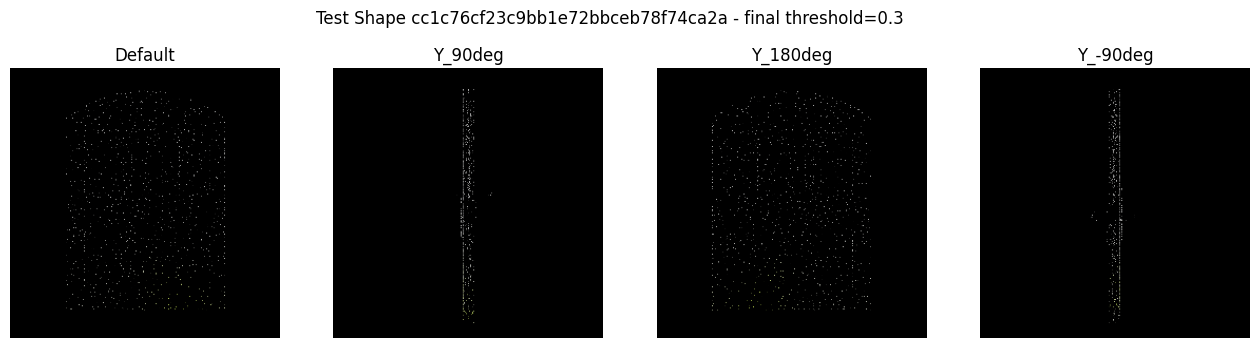

In [18]:
import torch
import matplotlib.pyplot as plt

# 1) Imports from your code
from src.data_loader_fullshape import create_dataset_splits, FullShapeDataset
from src.prompt_strategies import generate_affordance_prompt
from src.Clip.clip_model import get_clip_model
from src.render.cloud_point_renderer import MultiViewPointCloudRenderer
from src.neural_highlighter import NeuralHighlighter


device = "cuda"

dataset = FullShapeDataset("/content/Affordance3DHighlighter/data/full_shape_train_data.pkl", device=device)
train_data, val_data, test_data = create_dataset_splits(dataset, val_ratio=0.1, test_ratio=0.1)


print(f"[Main] val_data size={len(val_data)}, test_data size={len(test_data)}")

# 3) Load CLIP model
clip_model, _, _ = get_clip_model("ViT-L/14")

# 4) Validation Phase: search best (strategy, threshold)
strategies_list = ["basic", "affordance_specific"]
thresholds_list = [0.3, 0.5]  # let's have 2 thresholds now
num_val_objects = 3          # how many shapes we pick from val
num_iterations_val = 200     # how many training steps

best_strat, best_th, best_val_iou = grid_search_validation(
    val_dataset=val_data,
    clip_model=clip_model,
    device=device,
    strategies=strategies_list,
    thresholds=thresholds_list,
    num_val_objects=num_val_objects,
    num_iterations=num_iterations_val,
    output_dir="./val_gridsearch"
)

print(f"\n[Main] Validation done => best strategy={best_strat}, threshold={best_th}, valIoU={best_val_iou:.3f}")

# 5) Test Phase
num_test_shapes = 3
test_iterations = 200
final_test_iou = test_phase_evaluation(
    test_dataset=test_data,
    clip_model=clip_model,
    best_strategy=best_strat,
    best_threshold=best_th,
    device=device,
    num_test_shapes=num_test_shapes,
    num_iterations=test_iterations,
    output_dir="./test_results"
)
print(f"[Main] Final test IoU => {final_test_iou:.3f}")


